In [2]:
import pandas as pd
import numpy as np
import cv2

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Visualisation Of Iamage data

In [4]:
import matplotlib.pyplot as plt

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
single_image = x_train[1]

In [7]:
single_image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [8]:
single_image.shape

(28, 28)

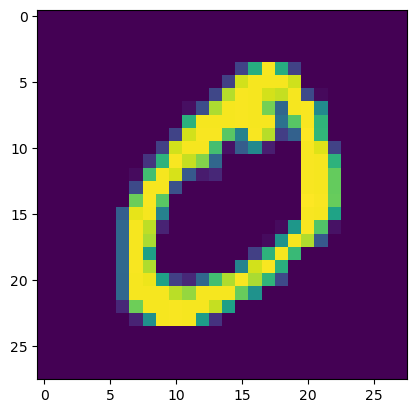

In [9]:
plt.imshow(single_image)

### Labels

In [10]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Hmmm, on dirait que nos labels sont littéralement des catégories de chiffres. Nous devons traduire cela par un encodage "one hot" pour que notre CNN puisse comprendre, sinon il pensera qu'il s'agit d'une sorte de problème de régression sur un axe continu. Heureusement, Keras dispose d'une fonction facile à utiliser pour cela :

In [12]:
from tensorflow.keras.utils import to_categorical

In [13]:
y_train.shape

(60000,)

In [14]:
y_example = to_categorical(y_train)

In [15]:
y_example

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [16]:
y_example.shape

(60000, 10)

In [17]:
y_example[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
y_cat_test = to_categorical(y_test,10)

In [19]:
y_cat_train = to_categorical(y_train,10)

### Processing X data

In [20]:
single_image.max()

255

In [21]:
single_image.min()

0

In [22]:
x_train = x_train/255
x_test = x_test/255

In [23]:
scaled_single = x_train[0]

In [24]:
scaled_single.max()

1.0

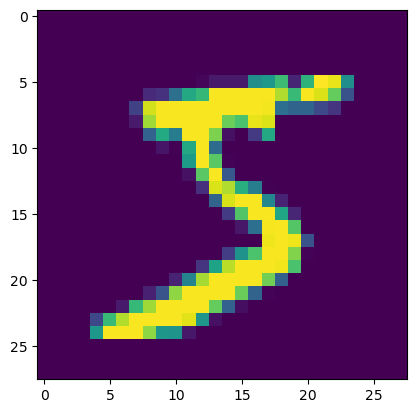

In [25]:
plt.imshow(scaled_single)

### Add a dimension to the data (B&W to RGB)

In [26]:
x_train.shape

(60000, 28, 28)

In [27]:
x_test.shape

(10000, 28, 28)

Remodeler pour inclure la dimension du canal (dans ce cas, 1 canal)

In [28]:
x_train = x_train.reshape(60000, 28, 28, 1)

In [29]:
x_train.shape

(60000, 28, 28, 1)

In [30]:
x_test = x_test.reshape(10000,28,28,1)

In [31]:
x_test.shape

(10000, 28, 28, 1)

## Création of the Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [33]:
model = Sequential()

# Couche convolutive
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(28, 28, 1), activation='relu',))
# Couche de Pooling
model.add(MaxPool2D(pool_size=(2, 2)))

# Images aplaties de 28 par 28 à 764 avant la couche finale
model.add(Flatten())

# 128 neurones dans une couche cachée Dense (vous pouvez changer ce nombre de neurones)
model.add(Dense(128, activation='relu'))

# La dernière couche est le calssificateur, donc 10 classes possibles
model.add(Dense(10, activation='softmax'))

# https://keras.io/metrics/
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # nous pouvons ajouter des metrics supplémentaires https://keras.io/metrics/

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
__________________________________________________

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Training

In [37]:
model.fit(x_train,y_cat_train,epochs=10,validation_data=(x_test,y_cat_test),callbacks=[early_stop])

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1318 - accuracy: 0.9601 - val_loss: 0.0495 - val_accuracy: 0.9844
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0455 - accuracy: 0.9861 - val_loss: 0.0415 - val_accuracy: 0.9856
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0474 - val_accuracy: 0.9844
Epoch 4/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0194 - accuracy: 0.9942 - val_loss: 0.0330 - val_accuracy: 0.9901
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0413 - val_accuracy: 0.9869
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0469 - val_accuracy: 0.9866


In [38]:
from tensorflow.keras.models import load_model
model.save('numero.h5')

In [ ]:
from tensorflow import keras
#model = keras.models.load_model('numero.h5')

## Évaluation of the model

In [40]:
model.metrics_names

['loss', 'accuracy']

In [41]:
losses = pd.DataFrame(model.history.history)

In [42]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.139041,0.957950,0.055861,0.9817
1,0.047455,0.985333,0.043056,0.9850
2,0.031116,0.989883,0.041938,0.9856
3,0.021344,0.993150,0.039678,0.9877
4,0.015407,0.994983,0.045386,0.9870


<AxesSubplot:>

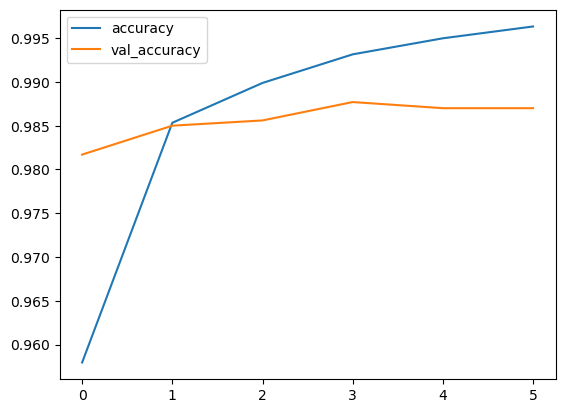

In [43]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

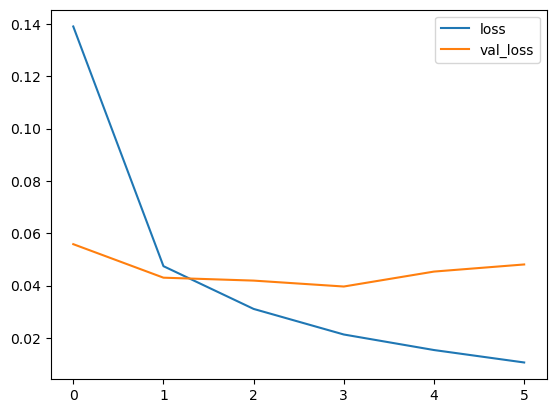

In [44]:
losses[['loss','val_loss']].plot()

In [45]:
print(model.metrics_names)
print(model.evaluate(x_test,y_cat_test,verbose=0))

['loss', 'accuracy']
[0.04810681939125061, 0.9869999885559082]


In [46]:
from sklearn.metrics import classification_report,confusion_matrix

In [47]:
predictions = np.argmax(model.predict(x_test), axis=1)

313/313 [==============================] - 2s 5ms/step


In [48]:
y_cat_test.shape

(10000, 10)

In [49]:
y_cat_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [50]:
predictions[0]

7

In [51]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [52]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.97      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [53]:
confusion_matrix(y_test,predictions)

array([[ 978,    0,    0,    1,    0,    0,    1,    0,    0,    0],
       [   0, 1130,    3,    0,    0,    0,    0,    1,    1,    0],
       [   1,    2, 1024,    0,    1,    0,    1,    3,    0,    0],
       [   0,    0,    2, 1002,    0,    2,    0,    1,    2,    1],
       [   0,    0,    2,    0,  971,    0,    0,    2,    3,    4],
       [   2,    0,    0,    7,    0,  880,    2,    0,    0,    1],
       [  11,    3,    0,    1,    2,    7,  933,    0,    1,    0],
       [   0,    2,    8,    1,    0,    0,    0, 1014,    0,    3],
       [   8,    1,    5,    1,    0,    0,    1,    2,  954,    2],
       [   4,    2,    0,    0,    7,    7,    0,    4,    1,  984]],
      dtype=int64)

In [54]:
import seaborn as sns

<AxesSubplot:>

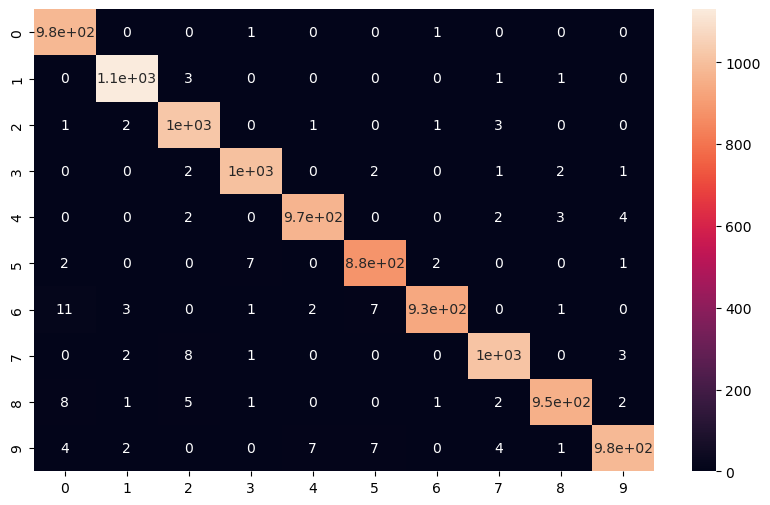

In [55]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)
# https://github.com/matplotlib/matplotlib/issues/14751

### Prediction of an image

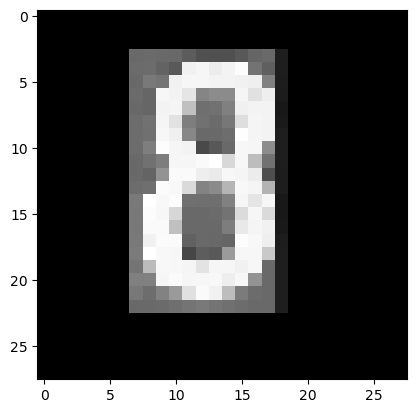

In [39]:
import cv2
from numpy import asarray
lol = cv2.imread(r'\data\letter3.png', cv2.IMREAD_GRAYSCALE)

imgr = cv2.resize(lol, (28,28), interpolation = cv2.INTER_LINEAR)
imgr = cv2.bitwise_not(imgr)

plt.imshow(imgr, cmap = 'gray')

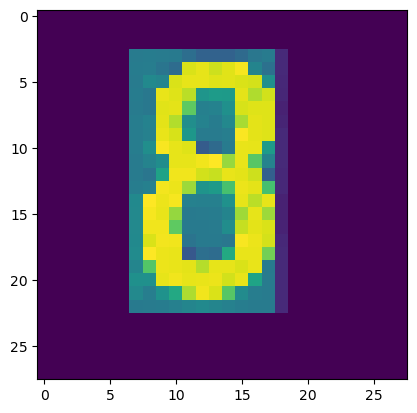

In [40]:
plt.imshow(imgr.reshape(28,28,1))

In [42]:
#lettre = np.argmax(model.predict(my_number.reshape(1,28,28,1)), axis=-1)
number = np.argmax(model.predict(imgr.reshape(1,28,28,1)), axis=-1)


list = ["0","1","2","3","4","5","6","7","8","9"]
type(number[0])

print(list[number[0]])

1/1 [==============================] - 0s 27ms/step
8


Works well!